# Tutorial about Mass transfer in membrane processes

Assuming total retention, what is the polarization module inside a tubular membrane (1[m] long), and a flat sheet membrane at the following two conditions:


*   $d_h$ = 10 [cm], $\mu$ = 0.001 [Pa s], $\rho$ = 1000 [kg/m$^3$], $U$ = 0.5 [m/s], $D$ = 1.5E-9 [m$^2$/s]
*   $d_h$ = 10 [cm], $\mu$ = 10 [Pa s], $\rho$ = 1400 [kg/m$^3$], $U$ = 0.5 [m/s], $D$ = 1.5E-9 [m$^2$/s]


 transmembrane flux of 0.01 [mm/s]

 Extra question: how sensitive is the polarzation to the retention ?
 Hint: include $C_p$ in the model equations and assume a retention of 70%, meaning $\frac{C_p}{C_b} = 0.3$

In [ ]:
import numpy as np

In [ ]:
# Start by defining the parameters
d_h = 0.1   # m
mu = 0.001  # Pa s
# mu = 10     # Pa s
rho = 1000  # kg/m^3
# rho = 1400  # kg/m^3
U = 0.1     # m/s
D = 1.5*(10**-9)   # m^2/s
L = 1       # m
J_v = 1e-5   # m/s

# Determine the Reynolds Number and the Schmidt Number
Re = U*d_h*rho/mu
Sc = mu/(rho*D)
print(f'Reynolds Number: {Re:.1f}')
print(f'Schmidt Number: {Sc:.0f}')

Reynolds Number: 1.4
Schmidt Number: 4761905


In [ ]:
# Based on the above result, use the appropriate correlation for the Sherwood Number

## Laminar flow, Tubular membrane:
# Sh = 1.62*(Re*Sc*(d_h/L))**0.33
## Laminar flow, Flat sheet membrane:
Sh = 0.664*(Re**0.5)*(Sc**0.33)
## Turbulent flow, Tubular membrane:
# Sh = 0.023*(Re**0.88)*(Sc**0.33)
## Turbulent flow, Flat sheet membrane:
# Sh = 0.036*(Re**0.8)*(Sc**0.33)
print(f'Sherwood Number: {Sh:.0f}')

Sherwood Number: 126


In [ ]:
# Now we can calculate the mass transfer coefficient using the definition of the Sherwood number
K_m = Sh*D/d_h
print(f'Mass transfer coefficient: {K_m} [m/s]')

Mass transfer coefficient: 1.883610006827256e-06 [m/s]


In [ ]:
# Finally, the polarization module can calculated
print(J_v/K_m)
PM = np.exp(J_v/K_m)
print(f'Polarization module: {PM}')

5.308954594504387
Polarization module: 202.13880088034662


#Extra tutorial about mass transfer in bioreactors

This is a simple monod type kinetic model describing the growth of a microorganism, the substrate consumption and product formation, coupled with an interfacial mass transfer model describing the oxygen mass transfer rate, in a batch reactor.


In [5]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define initial conditions of the simulation
x0 = 0.025 # g/L   Biomass concentration
s0 = 70    # g/L   Substrate concentration
p0 = 0     # g/L   Product concentration
o0 = 0     # g/L   Dissolved oxygen concentration
ini = [x0, s0, p0, o0]

In [ ]:
# Define model parameters
Ks = 0.79     # g/L Substrate limitation constant
Yxs = 0.0857  # g/g Substrate to biomass yield
alpha = 5.59  # g/g Biomass to product yield
Osat = 0.007  # g/L Oxygen saturation at 25C, 1atm (from Henrys law)
kla = 300     # h^-1 Gas-Liquid mass transfer coefficient
Yso = 0.2266  # gO2/gGlucose Oxygen to substrate yield
mu_max = 2.16 # h^-1 Maximum growth rate of the microorganism
Ko = 0.001    # g/L Oxygen limitation constant
par = (Ks, Yxs, alpha, Osat, kla, Yso, mu_max, Ko)

Batch operation equations:

In [ ]:
# Define the model equations
def batch(t, y, par):
  # Call parameters
  x, s, p, o = y
  Ks, Yxs, alpha, Osat, kla, Yso, mu_max, Ko = par
  # Emperical Monod equation
  mu = mu_max * (s/(Ks+s)) * (o/(Ko+o))
  # system of ODE to be solved
  dxdt = mu * x
  dsdt = -dxdt / Yxs
  dpdt = alpha * dxdt
  dodt = (kla * (Osat - o)) - (Yso * (-dsdt))
  return [dxdt, dsdt, dpdt, dodt]

In [ ]:
# Run the simulation
tspan = (0, 10) # hours
sol = solve_ivp(batch, tspan, ini, method='Radau', args=(par,))

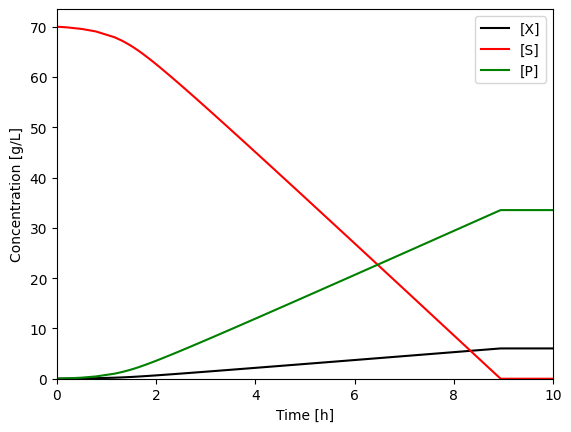

In [ ]:
# Plotting the results using matplotlib
plt.figure()
plt.plot(sol.t, sol.y[0], 'k-', label='[X]')
plt.plot(sol.t, sol.y[1], 'r-', label='[S]')
plt.plot(sol.t, sol.y[2], 'g-', label='[P]')
plt.xlabel('Time [h]')
plt.ylabel('Concentration [g/L]')
plt.xlim(tspan)
plt.ylim (0,)
plt.legend()

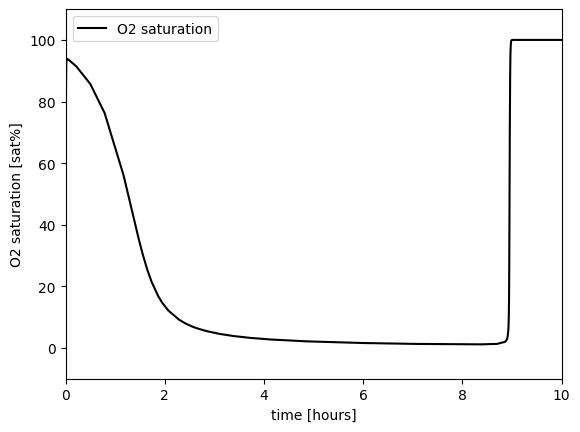

In [ ]:
# Plotting the dissolved oxygen concentration
plt.figure()
plt.plot(sol.t, (sol.y[3]*100/Osat),'k-',label='O2 saturation')
plt.xlabel('time [hours]')
plt.ylabel('O2 saturation [sat%]')
plt.xlim(tspan)
plt.ylim(-10,110)
plt.legend()


Exercise: modify the model equations to simulate a fedbatch fermentation and a continuous fermentation.
Parameters for the fedbatch reactor:


*   V$_{initial}$ = 200 [L]
*   F = 0.1 [m$^3$/h]
*   Sf = 70 [g/L]
*   S0 = 10 [g/L]
*   Max working volume = 500 [L]

Parameters for the continuous reactor


*   D = 0.1 [h$^{-1}$]
*   Sf = 70 [g/L]
*   S0 = 70 [g/L]

SPOILER!! the solution to the fedbatch reactors is shown bellow!

Extra exercise: use an optimizer to optimize the final product concentration by changing the feeding rate (max feeding rate is 200 [L/h]). <br>
<u>HINT:</u> use the Scipy.optimise.minimize package and define constraints.

##FEDBATCH MODEL

In [10]:
# Define initial conditions of the simulation
x0 = 0.025*10 # g/L   Biomass concentration
s0 = 10    # g/L   Substrate concentration
p0 = 0     # g/L   Product concentration
o0 = 0     # g/L   Dissolved oxygen concentration
V0 = 200   # L
ini = [x0, s0, p0, o0, V0]

In [17]:
# Define model parameters, including the fedbatch parameters
Ks = 0.79     # g/L Substrate limitation constant
Yxs = 0.0857  # g/g Substrate to biomass yield
alpha = 5.59  # g/g Biomass to product yield
Osat = 0.007  # g/L Oxygen saturation at 25C, 1atm (from Henrys law)
kla = 300     # h^-1 Gas-Liquid mass transfer coefficient
Yso = 0.2266  # gO2/gGlucose Oxygen to substrate yield
mu_max = 2.16 # h^-1 Maximum growth rate of the microorganism
Ko = 0.001    # g/L Oxygen limitation constant
F = 50        # L/h Feeding rate
Sf = 70       # g/L Substrate concentration in the feed
par = (Ks, Yxs, alpha, Osat, kla, Yso, mu_max, Ko, F, Sf)

In [46]:
def fedbatch(t, y, par):
  # Call parameters
  x, s, p, o, V = y
  Ks, Yxs, alpha, Osat, kla, Yso, mu_max, Ko, F, Sf = par
  # Limiting the feeding to the max volume with an "if" statement
  if V > 700:
    F=0
  # Emperical Monod equation
  mu = mu_max * (s/(Ks+s)) * (o/(Ko+o))
  # system of ODE to be solved
  dxdt = (mu * x) - x*(F/V)
  dsdt = -((mu * x) / Yxs) + ((Sf-s)*(F/V))
  dpdt = alpha * dxdt - p*(F/V)
  dodt = (kla * (Osat - o)) - (Yso * ((mu * x) / Yxs)) - o*(F/V)
  dVdt = F
  return [dxdt, dsdt, dpdt, dodt, dVdt]

In [47]:
# Run the simulation
tspan = (0, 10) # hours
sol = solve_ivp(fedbatch, tspan, ini, method='RK45', args=(par,))

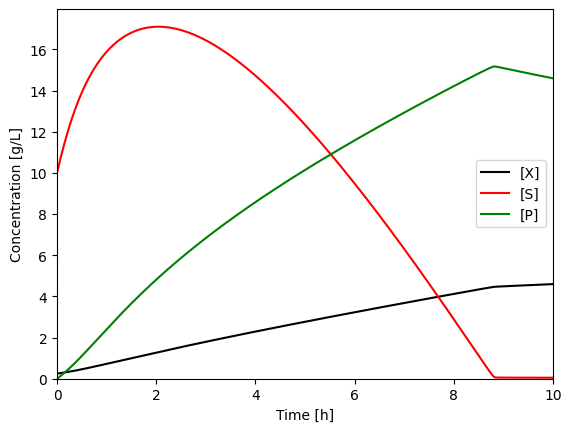

In [48]:
# Plotting the results using matplotlib
plt.figure()
plt.plot(sol.t, sol.y[0], 'k-', label='[X]')
plt.plot(sol.t, sol.y[1], 'r-', label='[S]')
plt.plot(sol.t, sol.y[2], 'g-', label='[P]')
plt.xlabel('Time [h]')
plt.ylabel('Concentration [g/L]')
plt.xlim(tspan)
plt.ylim (0,)
plt.legend()

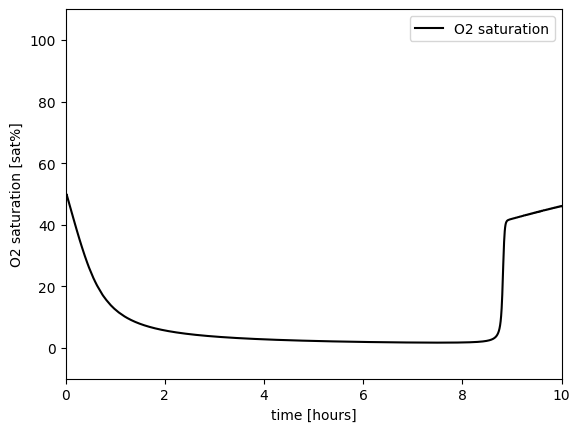

In [49]:
# Plotting the dissolved oxygen concentration
plt.figure()
plt.plot(sol.t, (sol.y[3]*100/Osat),'k-',label='O2 saturation')
plt.xlabel('time [hours]')
plt.ylabel('O2 saturation [sat%]')
plt.xlim(tspan)
plt.ylim(-10,110)
plt.legend()

Text(0, 0.5, 'Liquid volume [L]')

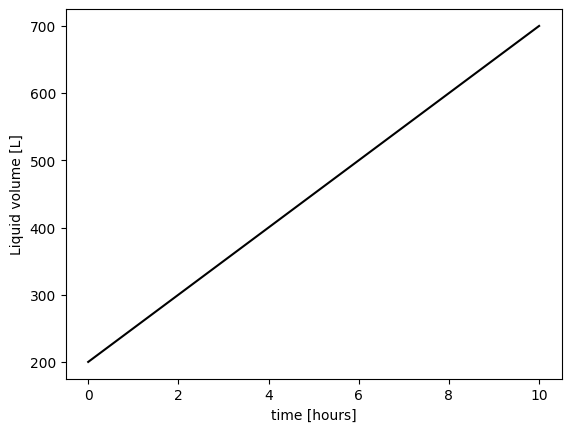

In [50]:
# Plotting the dissolved oxygen concentration
plt.figure()
plt.plot(sol.t, (sol.y[4]),'k-',label='liquid volume')
plt.xlabel('time [hours]')
plt.ylabel('Liquid volume [L]')

## Continuous reactor model

In [ ]:
## Now your turn to implement the continuous reactor with the given parameters